In [50]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [55]:
eps = [i*1/100 for i in range(1, 11)]
min_samples = [j for j in range(10, 21)]

print(eps)
print(min_samples)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


# SOPR 지표

In [56]:
df_interval = pd.read_excel('./data/변동성_구간.xlsx')

start = list(df_interval['start_date'])
end =  list(df_interval['end_date'])

In [54]:
sopr_df = pd.read_excel('./data/SOPR 비율 (장기 보유자 SOPR.xlsx')
sopr_df['날짜'] = pd.to_datetime(sopr_df['날짜'], format = "%Y %m %d")
sopr_df['가격'] = sopr_df['가격'].str.replace(',', '').astype(float)
sopr_df['가격'] = pd.to_numeric(sopr_df['가격'], errors='coerce')
new_columns = {'날짜':'DATE','가격':'PRICE','SOPR 비율 (장기 보유자 SOPR/단기 보유자 SOPR)':'SOPR_RATE'}
sopr_df = sopr_df.rename(columns=new_columns)

scaler = MinMaxScaler()
sopr_df[['scaled_SOPR_RATE']] = scaler.fit_transform(sopr_df[['SOPR_RATE']])
X = sopr_df[['scaled_SOPR_RATE']].values

In [57]:




best_f1_score = 0           #
best_eps = 0                #
best_min_samples = 0        #
best_outlier_ratio = 0      #
best_outlier_eps = 0        #
best_outlier_min_samples = 0#

for mins in min_samples:
    for e in eps:
        dbscan = DBSCAN(eps=e, min_samples=mins).fit(X)
        labels = dbscan.labels_
        data = pd.Series(labels).value_counts()
        sopr_df['label'] = labels

        print('★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆')

        labeled_date = sopr_df['DATE'][sopr_df['label'] == -1]
        outliner = list(labeled_date)

        X_IN_GREY_BG = 0
        # X_IN_WHITE_BG = 0
        NO_X_IN_GREY_BG = 0
        # NO_X_IN_WHITE_BG = 0

        for i in range(len(df_interval)):
            # print(start[i], end[i])
            for j in range(len(outliner)):
                if start[i] <= outliner[j] <= end[i]:
                  # print(outliner[j], j)
                  X_IN_GREY_BG += 1
                  break

        print('X_IN_GREY_BG: ',X_IN_GREY_BG)

        NO_X_IN_GREY_BG = len(df_interval) - X_IN_GREY_BG
        print('NO_X_IN_GREY_BG:', NO_X_IN_GREY_BG)

        from datetime import datetime, timedelta

        # X_IN_GREY_BG = 0
        X_IN_WHITE_BG = 0
        # NO_X_IN_GREY_BG = 0
        NO_X_IN_WHITE_BG = 0

        WHITE_Start = []
        WHITE_End = []

        WHITE_Start.append(sopr_df['DATE'].min())
        WHITE_End.append(start[0] - timedelta(days=1))

        # 겹치지 않는 기간 찾기
        for i in range(len(start)):
            if i < len(start) - 1 and end[i] < start[i + 1]:
                WHITE_Start.append(end[i] + timedelta(days=1))
                WHITE_End.append(start[i + 1] - timedelta(days=1))

        WHITE_Start.append(end[-1] + timedelta(days=1))
        WHITE_End.append(sopr_df['DATE'].max())

        from datetime import datetime, timedelta

        X_IN_WHITE_BG = 0
        NO_X_IN_WHITE_BG = 0

        # 기간 내의 outliner 체크
        for i in range(len(WHITE_Start)):
            for j in range(len(outliner)):
                if WHITE_Start[i] <= outliner[j] <= WHITE_End[i]:
                    X_IN_WHITE_BG += 1
                    # print(outliner[j])
                    break

        NO_X_IN_WHITE_BG = len(WHITE_Start) - X_IN_WHITE_BG

        # print('X_IN_WHITE_BG:', X_IN_WHITE_BG)
        # print('NO_X_IN_WHITE_BG:', NO_X_IN_WHITE_BG)

        F1_Precision = X_IN_GREY_BG / (X_IN_GREY_BG + X_IN_WHITE_BG)
        F1_Recall = X_IN_GREY_BG / (X_IN_GREY_BG + NO_X_IN_GREY_BG)
        F1_Score = 2 * (F1_Precision * F1_Recall) / (F1_Precision + F1_Recall)
        print('F1_Score: ', F1_Score)

        print(f'For eps={e}, min_samples={mins}, F1_Score: {F1_Score}')

        # 최고 F1 스코어 업데이트 및 조합 저장
        if F1_Score > best_f1_score:
            best_f1_score = F1_Score
            best_eps = e
            best_min_samples = mins


        # start와 end 사이 기간 안에 포함되는 outliner 개수 초기화
        included_outliner_count = 0

        # 각 outliner가 어떤 기간에 속하는지 확인하고 개수 세기
        for i in range(len(outliner)):
            for j in range(len(start)):
                if start[j] <= outliner[i] <= end[j]:
                    included_outliner_count += 1
                    # print(start[j])
                    # print(end[j])
                    # print(i)
                    # print('outliner[i] ', outliner[i])
                    break

        print(f"start와 end 기간 안에 포함되는 outliner 개수: {included_outliner_count}")
        excluded_outliner_count = len(outliner) - included_outliner_count
        outlier_ratio = (included_outliner_count+1) / (excluded_outliner_count + 1)

        if outlier_ratio > best_outlier_ratio:
            best_outlier_ratio = outlier_ratio
            best_f1_score = F1_Score
            best_eps = e
            best_min_samples = mins

            # 최고의 변동성 안 이상치 비율일 때의 eps와 min_samples 저장
            best_outlier_eps = e
            best_outlier_min_samples = mins

        print('변동성 안 이상치 개수 / 변동성 밖 이상치 개수: ', outlier_ratio)


        # print('★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆')


        print('데이터 총수', data[0]+data[-1])
        print('eps={}, min_samples={}일때 이상치의개수 : {}'.format(e,mins,data[-1]))
        print('-'*50)
  
  
  

print(f'Best F1 Score: {best_f1_score} for eps={best_eps}, min_samples={best_min_samples}')
print(f'Best Outlier Ratio: {best_outlier_ratio} for eps={best_outlier_eps}, min_samples={best_outlier_min_samples}')


★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆
X_IN_GREY_BG:  7
NO_X_IN_GREY_BG: 7
F1_Score:  0.5833333333333334
For eps=0.01, min_samples=10, F1_Score: 0.5833333333333334
start와 end 기간 안에 포함되는 outliner 개수: 46
변동성 안 이상치 개수 / 변동성 밖 이상치 개수:  7.833333333333333
데이터 총수 1031
eps=0.01, min_samples=10일때 이상치의개수 : 51
--------------------------------------------------
★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆
X_IN_GREY_BG:  6
NO_X_IN_GREY_BG: 8
F1_Score:  0.5454545454545454
For eps=0.02, min_samples=10, F1_Score: 0.5454545454545454
start와 end 기간 안에 포함되는 outliner 개수: 16
변동성 안 이상치 개수 / 변동성 밖 이상치 개수:  4.25
데이터 총수 1094
eps=0.02, min_samples=10일때 이상치의개수 : 19
--------------------------------------------------
★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆★☆
X_IN_GREY_BG:  6
NO_X_IN_GREY_BG: 8
F1_Score:  0.5454545454545454
For eps=0.03, min_samples=10, F1_Score: 0.5454545454545454
start와 end 기간 안에 포함되는 outliner 개수: 9
변동성 안 이상치 개수 / 변동성 밖 이상치 개수:  3.3333333333333335
데이터 총수 1094
eps=0.03, min_samples=10일때 이상치의개수 : 11
--------------------------

In [58]:
dbscan = DBSCAN(eps=0.01, min_samples=14).fit(X)
labels = dbscan.labels_
print(pd.Series(labels).value_counts())
sopr_df['label'] = labels

 0    939
-1    122
 1     18
 2     15
Name: count, dtype: int64


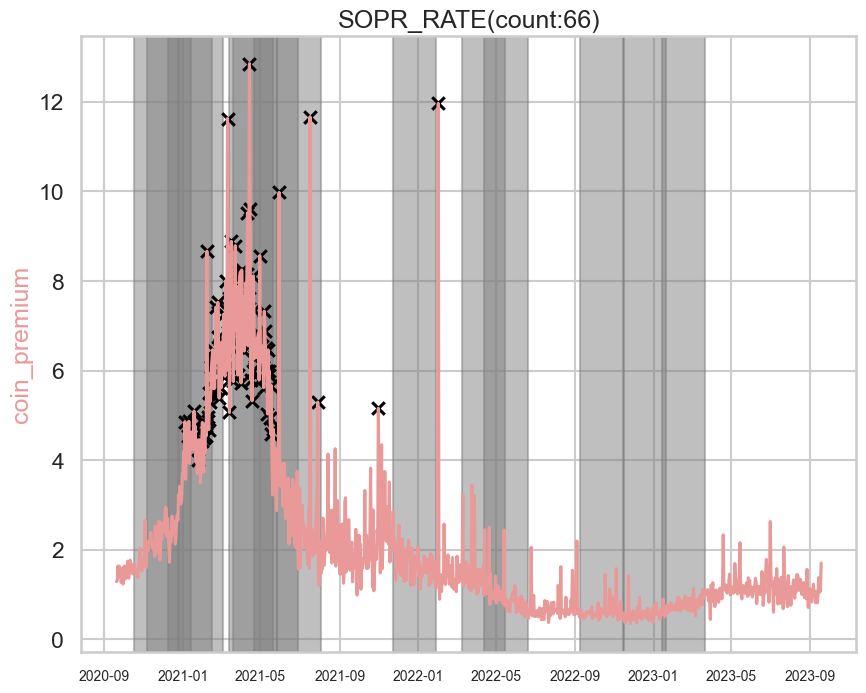

In [62]:

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context('talk')

fig, ax2 = plt.subplots(figsize=(10, 8))
for index, row in df_interval.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    ax2.axvspan(start_date, end_date, color='gray', alpha=0.5)
    
ax2.plot(sopr_df['DATE'], sopr_df['SOPR_RATE'], label='MPI',color='#EA9999')
ax2.set_ylabel('coin_premium',color='#EA9999')
ax2.tick_params(axis='y',color='#EA9999')
# ax2.legend(loc='upper right')


label_minus_1 = sopr_df[sopr_df['label'] == -1]
ax2.scatter(label_minus_1['DATE'], label_minus_1['SOPR_RATE'], marker='x', color='black', label='SOPR_RATE (-1)')

# 그래프 제목 설정
plt.title('SOPR_RATE(count:66)')
plt.xticks(fontsize=10, rotation=0)
plt.grid(True)



# 그래프 표시
plt.show()

# Coinbase 지표